## Import 

In [1]:
import numpy as np
from scipy.fftpack import dct
import scipy.io.wavfile
import matplotlib.pyplot as plt
import os
import hashlib
import re
from hmmlearn import hmm
import pickle
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from prettytable import PrettyTable
from prettytable import PLAIN_COLUMNS


## Function for plot the signal amplitude over the time and fiterbank

In [2]:
def plotSignal(time, signal):
    plt.plot(time , signal)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    
def plotFilterbank(fbank_matrix):
    plt.plot(fbank_matrix[:,:].T)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.savefig('filterbanks.pdf')
    
    

# Function for extract features Mel-Frequency Cepstral Coefficients (MFCCs) and Delta from audio source

In [3]:
def get_features(file_path, pre_emphasis = 0.95, frame_size = 0.025, frame_step = 0.01, NFFT = 512,\
                 nfilt = 26, low_freq_hz = 300, num_ceps = 12):
    
    """
    Args:
        file_path: File path of the data sample.
        pre_emphasis: filter coefficient for pre emphasis phase.
        frame_size: size of the frames in framing phase.
        frame_step: size of the overlap in framing phase.
        NFFT: point numbers of discrete Fourier Transform (DFT).
        nfilt: number of filters used in filter Banks calulation phase.
        low_freq_hz: lower frequency used in filter Banks calulation phase.
        num_ceps: number of Cepstral Coefficients. 

    Returns:
        numpy array, of features: MFFCCs and delta coefficients.
    """
    sample_rate, signal = scipy.io.wavfile.read(file_path)
        
        
    time = np.linspace(0,signal.shape[0]/sample_rate, signal.shape[0])
    #plotSignal(time, signal)

    #Preemphasis
    signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[: -1])
    #plotSignal(time, signal)

    #Framing
    signal_length = len(signal)
    frame_length = int(frame_size * sample_rate)
    step_length = int(frame_step * sample_rate)
    signal_framing = np.empty((0,frame_length),float)


    num_frames = int(np.ceil(float(np.abs(signal_length-frame_length))/step_length))+1
    pad_signal_length = (frame_length + num_frames * step_length) - signal_length
    pad_signal = np.zeros(pad_signal_length)
    signal = np.append(signal,pad_signal)

    indices_matrix = np.tile(np.arange(0,frame_length),(num_frames,1))
    offset_indices = np.arange(0,step_length*num_frames,step_length)
    indices_matrix = (indices_matrix[0:].T + (offset_indices[0:])).T
    frames = signal[indices_matrix.astype(np.int32, copy=False)]

    #Windowing
    #Explicit implementation:
    #w = np.arange(0,frame_length)
    #w = 0.54 - 0.46 * np.cos((2 * np.pi * w) / (frame_length - 1))
    #frames*=w
    frames *= np.hamming(frame_length)

    #Discrete Fourier Transformation
    magnitude_frames = np.absolute(np.fft.rfft(frames, NFFT))

    #Power spectrum
    pow_frames = (magnitude_frames ** 2) / NFFT

    #Compute energy
    energy = np.sum(pow_frames, axis = 1)

    #Filter Banks
    # nfilt = filters number
    # low_freq_hz = 300 usually default is 0 (set to 300 for discard too low frequency,\
    # likely generated from noise)
    highfreq = sample_rate / 2
    low_freq_mel = (2595 * np.log10(1 + low_freq_hz / 700.))  # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + highfreq / 700.))  # Convert Hz to Mel

    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2 ) # Equally spaced in Mel scale
    hz_points = (700 * (10** (mel_points / 2595.0) - 1 )) # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate) # our points are in Hz, but we use fft bins,\
                                                         # so we have to conver from Hz to fft bin number

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

    for j in range(0,nfilt):
            for i in range(int(bin[j]), int(bin[j+1])):
                fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
            for i in range(int(bin[j+1]), int(bin[j+2])):
                fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])


    # Plot filterbank if you want           
    #plotFilterbank(fbank)         

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # if energy is zero, we get problems with log
    filter_banks = np.log10(filter_banks)  # dB

    #Mel Frequency Cepstral Coefficients
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 0:(num_ceps)] # Keep 0 to num_ceps-1
    mfcc[:, 0] = np.log(energy + 1e-8)  # the zeroth cepstral coefficient is replaced with the log of\
                                        # the total frame energy


    cep_lifter = 22
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift  

    #Mean normalization 
    filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

    #Delta compute
    N = 2
    num_frames = mfcc.shape[0]
    denominator = 2 * sum([n**2 for n in range(1, N+1)])
    delta_feat = np.empty_like(mfcc)
    padded = np.pad(mfcc, ((N, N), (0, 0)), mode='edge')   # padded version of feature vectors(mfcc) (appending N*2 rows)
    for t in range(num_frames):
        delta_feat[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]

    #Append mfcc and Delta features
    features = np.append(mfcc, delta_feat, axis = 1)
    return features


# Split training and test set

In [4]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M
def which_set(filename, training_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        training_percentage: How much of the data set to use for training.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', or 'testing'.
    """
    base_name = os.path.basename(filename)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name.encode()).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < training_percentage:
        result = 'training'
    else:
        result = 'testing'
    return result

# SPEECH COMMANDS DATA SET v0.02

# Compute vectors of features and store labels lists for training and test

In [5]:
#txt_train = open("training_list.txt", "x")
#txt_test = open("testing_list.txt", "x")
path_dataset = "Dataset/speech_commands_v0.01"
#path_dataset = "Dataset/speech_commands_v0.02"
#path_dataset = "Dataset/fruits"
train_dict = {}
test_dict = {}
for root_dir, sub_dir, file in os.walk(path_dataset):
    sub_dir[:] = [d for d in sub_dir if d not in ['_background_noise_'] ]
    for wave in file:
        if(re.match('.*\.wav$',wave)):
            file_path = (os.path.join(root_dir, wave))
            label = os.path.relpath(root_dir, path_dataset)
            feature = get_features(file_path)
            partition = which_set(wave, 80, 20)
            
            if (partition == 'training'):
                if (label not in train_dict):
                    train_dict[label] = []
                    train_dict[label].append(feature)
                else:
                    train_dict[label].append(feature)
                #txt_train.write(label + "/" + wave + "\n")
                
            elif (partition == 'testing'):
                if (label not in test_dict):
                    test_dict[label] = []
                    test_dict[label].append(feature)
                else:
                    test_dict[label].append(feature)  
                #txt_test.write(label + "/"+ wave + "\n")
            else:
                continue
#txt_train.close()
#txt_test.close()

words = list(train_dict) # save unique single words into the train dataset 

# Train HMMs with Gaussian mixture emissions, one  for each word and save it on models folder

In [14]:
GMMHMM_models = {} # dict of HMMs (one model for each word into the dataset)
num_states = 3 # States number of HMM
num_mix = 7 # number of mixtures for each hidden state
covariance_type = 'diag'  # covariance type
num_iter = 10  # number of max iterations
bakis_level = 2

start_prob = np.zeros(num_states) # start probability prior
start_prob[0:bakis_level - 1] = 1 / float(1 / (bakis_level - 1))

trans_mat = np.eye(num_states) # transaction matrix probability prior 
for i in range(num_states - (bakis_level - 1)):
    for j in range(bakis_level):
        trans_mat[i, i + j] = 1 / bakis_level

for i in range((num_states - (bakis_level ) + 1), num_states ):
    trans_mat[i,i:] = (1 / (num_states - i))

model_number = 0
for word in train_dict:
    model = hmm.GMMHMM(n_components = num_states, n_mix = num_mix, startprob_prior = start_prob,\
                               transmat_prior = trans_mat, covariance_type = covariance_type,\
                               n_iter = num_iter, verbose=False)

    train_samples = train_dict[word]
    length_samples = np.zeros(len(train_samples), dtype=np.int) # lenght_samples = length (number of\
                                                                # frames) of each sample of word
    for elem in range(len(train_samples)):
        length_samples[elem] = train_samples[elem].shape[0]

    train_samples = np.vstack(train_samples) # Stack arrays in train_samples in sequence vertically 
    model.fit(train_samples)

    GMMHMM_models[word] = model
    print("Finish train model GMM-HMM %s" % model_number)
    model_number += 1
num_words = len(train_dict)
print("Finish train %s GMM-HMMs for %s different words" % (num_words, num_words))


trained_model = GMMHMM_models
"""
Save model to file
"""

with open("models/model.pkl", "xb") as file: 
    pickle.dump(trained_model, file, pickle.HIGHEST_PROTOCOL)
    
    
    
"""
Load model from file
"""
"""
For the loading of pre trained model   
with open("models/model.pkl", "rb") as file: 
    trained_model = pickle.load(file)
    
"""
print("")


    
    

Finish train model GMM-HMM 0
Finish train model GMM-HMM 1
Finish train model GMM-HMM 2
Finish train model GMM-HMM 3
Finish train model GMM-HMM 4
Finish train model GMM-HMM 5
Finish train model GMM-HMM 6
Finish train model GMM-HMM 7
Finish train model GMM-HMM 8
Finish train model GMM-HMM 9
Finish train model GMM-HMM 10
Finish train model GMM-HMM 11
Finish train model GMM-HMM 12
Finish train model GMM-HMM 13
Finish train model GMM-HMM 14
Finish train model GMM-HMM 15
Finish train model GMM-HMM 16
Finish train model GMM-HMM 17
Finish train model GMM-HMM 18
Finish train model GMM-HMM 19
Finish train model GMM-HMM 20
Finish train model GMM-HMM 21
Finish train model GMM-HMM 22
Finish train model GMM-HMM 23
Finish train model GMM-HMM 24
Finish train model GMM-HMM 25
Finish train model GMM-HMM 26
Finish train model GMM-HMM 27
Finish train model GMM-HMM 28
Finish train model GMM-HMM 29
Finish train 30 GMM-HMMs for 30 different words


FileExistsError: [Errno 17] File exists: 'models/model.pkl'

# Predict test set

In [15]:
score_count = 0
words_number = 0
y_true = []
y_pred = []
for word in test_dict.keys():
    test_samples = test_dict[word]
    for speech_word in test_samples:
        words_number += 1
        score_models = {}
        for word_model in trained_model.keys():
            model = trained_model[word_model]
            score = model.score(speech_word)
            score_models[word_model] = score
        predict_word = max(score_models, key = score_models.get)
        #print("Test on true label ", word, ": predict result label is ", predict_word)
        y_true.append(word)
        y_pred.append(predict_word)
        if predict_word == word:
            score_count += 1

            
accuracy = (100 * score_count / words_number)              
print("Recognition rate %s" %(accuracy))
            
        
        

Recognition rate 76.60264202933787


# Confusion matrix

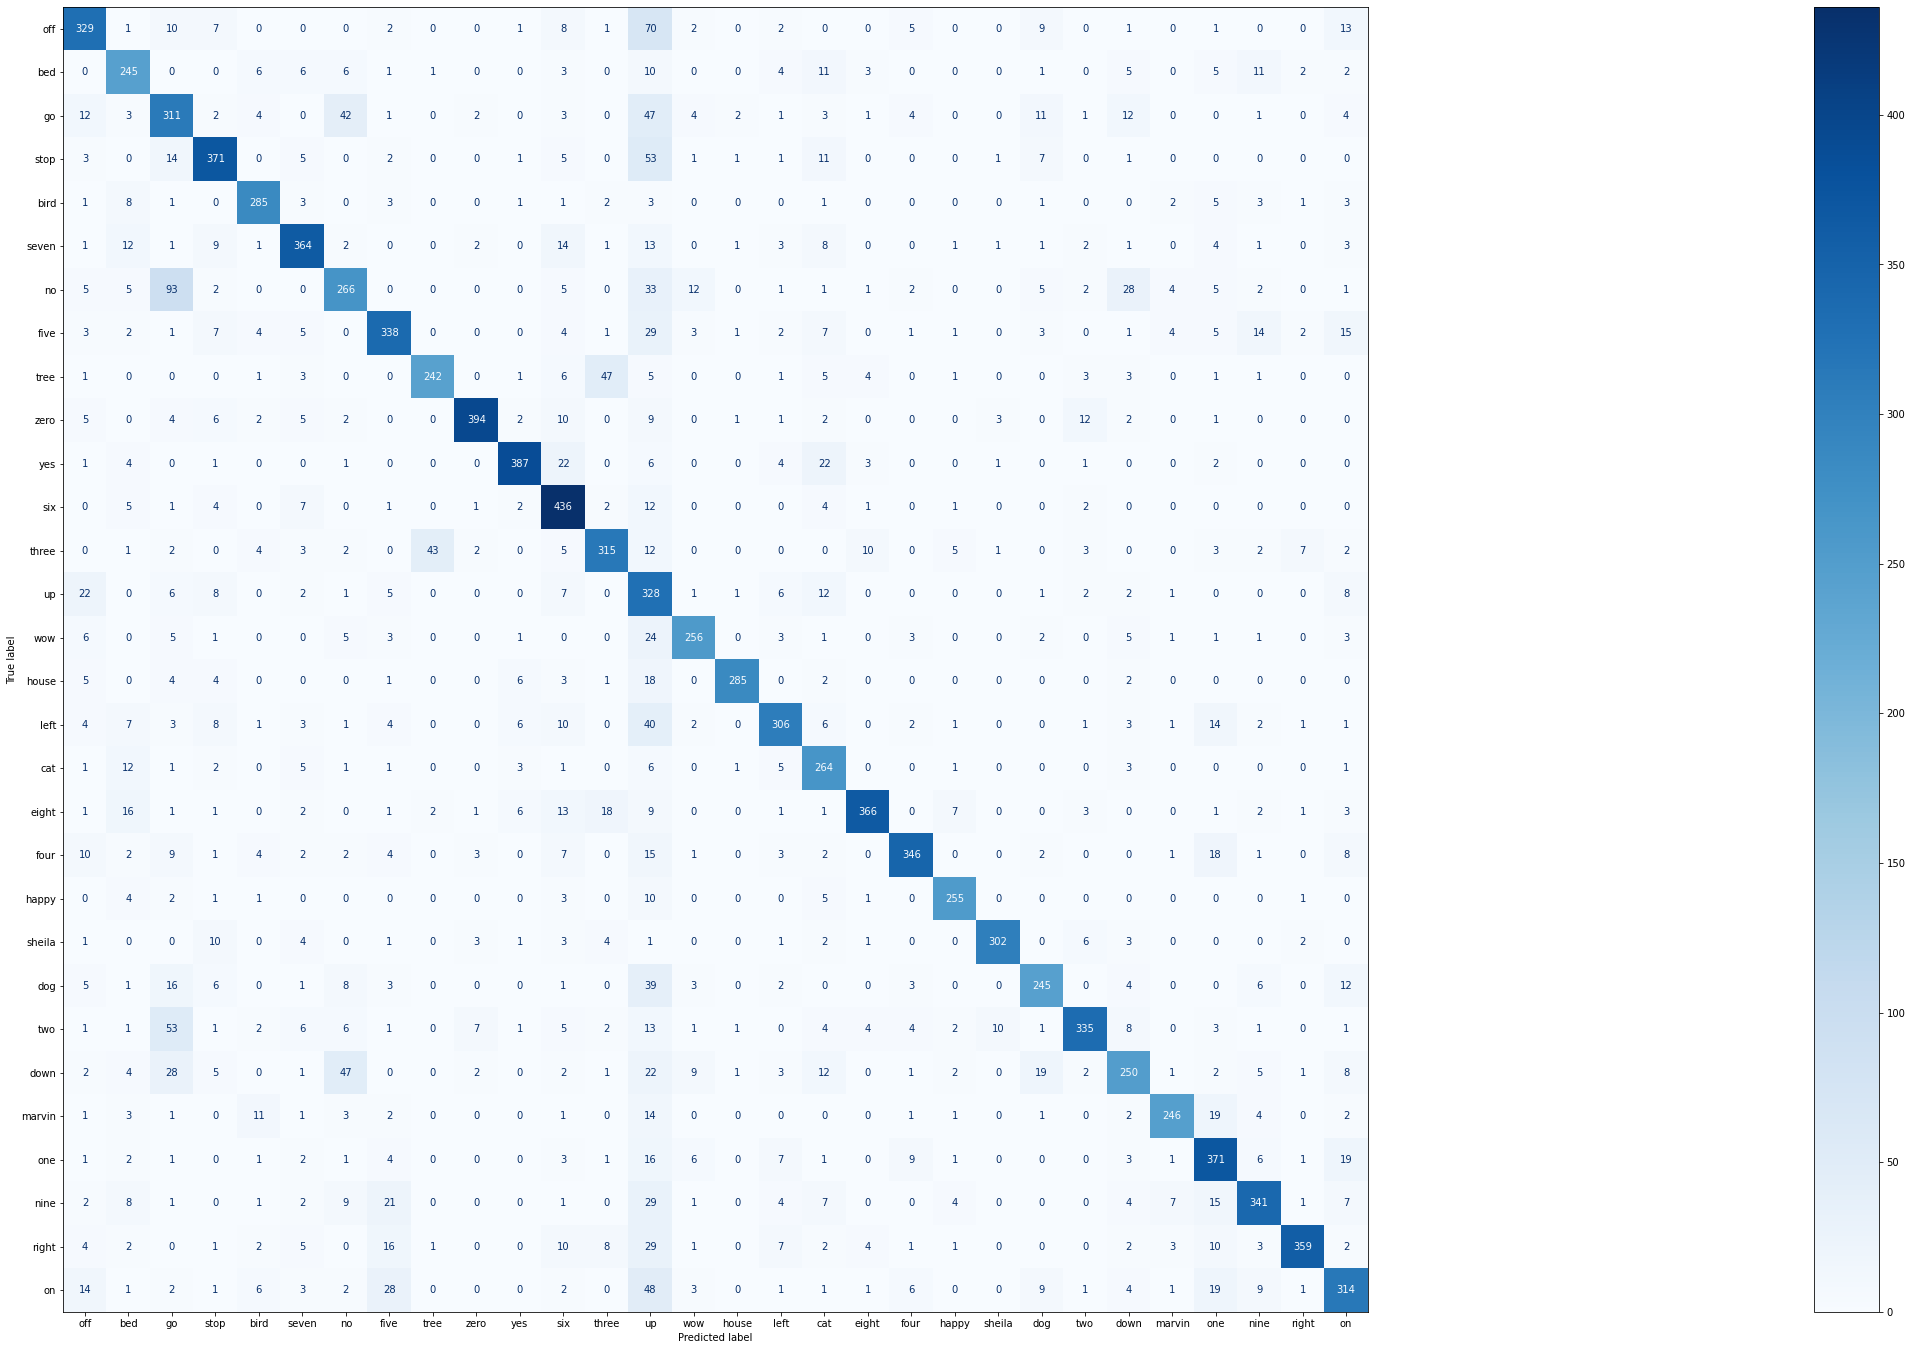

In [16]:
plt.rcParams["figure.figsize"] = (160,24)

cm = confusion_matrix(y_true, y_pred, labels = words)
disp = ConfusionMatrixDisplay(cm, display_labels = words)
disp = disp.plot(cmap=plt.cm.Blues)
plt.margins(0,0)
#plt.savefig('speech_commands_datasetv0.02_conf_mat.pdf', bbox_inches='tight')
plt.show()


# Compute Precision, Recall and F1 score indexes

In [10]:
precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, labels = words)
print('precision: ', precision)
print('recall: ', recall)
print('fscore: ', fscore)
print('support: ', support)

precision:  [0.81922197 0.67848101 0.68493151 0.9239905  0.89375    0.85201794
 0.756691   0.87469287 0.88014981 0.93981481 0.95899772 0.79890311
 0.81534772 0.4137931  0.92307692 0.94224924 0.83018868 0.7827381
 0.93095238 0.87816092 0.93478261 0.98402556 0.90070922 0.83296703
 0.66943867 0.97378277 0.85242291 0.86363636 0.90182648 0.77235772]
recall:  [0.77489177 0.83229814 0.63694268 0.81551363 0.88271605 0.85201794
 0.65750529 0.78587196 0.72307692 0.88069414 0.92527473 0.91231733
 0.8056872  0.81355932 0.82242991 0.93655589 0.82435597 0.8538961
 0.85745614 0.86621315 0.91166078 0.89275362 0.71549296 0.79957806
 0.74883721 0.83067093 0.84682713 0.85806452 0.83509514 0.7966457 ]
fscore:  [0.79644049 0.74755927 0.66006601 0.86636971 0.88819876 0.85201794
 0.70361991 0.82790698 0.79391892 0.90929451 0.94183445 0.85185185
 0.81048868 0.54857143 0.86985173 0.93939394 0.82726204 0.81677019
 0.89269406 0.87214612 0.92307692 0.93617021 0.79748823 0.81593111
 0.70691548 0.89655172 0.8496158

In [11]:
total_samples = np.sum(support)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, \
                                                                             labels = words, average = 'macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred,\
                                                                             labels = words, average = 'weighted')

In [12]:
blank = [" ", " ", " ", " ", " "]
x = PrettyTable()
#x.set_style(PLAIN_COLUMNS)

column_names = ["\033[1mLabels", "Precision", "Recall", "Fscore", "Support\033[0m"]
#x.field_names = column_names
x.align["\033[1mLabels"] = "l"
x.add_column(column_names[0], words)
x.add_column(column_names[1],np.around(precision,2))
x.add_column(column_names[2],np.around(recall,2))
x.add_column(column_names[3],np.around(fscore,2))
x.add_column(column_names[4],np.around(support,2))
x.add_row(blank)
x.add_row(blank)

x.add_row(["\033[1m Avg \033[0m", np.around(precision_m,2), np.around(recall_m,2), \
           np.around(fscore_m,2), total_samples])
x.add_row(["\033[1m Weighted Avg \033[0m", np.around(precision_w,2), np.around(recall_w,2),\
           np.around(fscore_w,2), total_samples])
x.add_row(["\033[1m Accuracy \033[0m", "", "", np.around(accuracy,2), total_samples])



In [13]:
print(x)
with open('speech_commands_datasetv0.01_precision_recall_fscore_support.txt', 'w') as f:
    f.write(str(x))

+----------------+-----------+--------+--------+---------+
|     Labels     | Precision | Recall | Fscore | Support |
+----------------+-----------+--------+--------+---------+
|      off       |    0.82   |  0.77  |  0.8   |   462   |
|      bed       |    0.68   |  0.83  |  0.75  |   322   |
|       go       |    0.68   |  0.64  |  0.66  |   471   |
|      stop      |    0.92   |  0.82  |  0.87  |   477   |
|      bird      |    0.89   |  0.88  |  0.89  |   324   |
|     seven      |    0.85   |  0.85  |  0.85  |   446   |
|       no       |    0.76   |  0.66  |  0.7   |   473   |
|      five      |    0.87   |  0.79  |  0.83  |   453   |
|      tree      |    0.88   |  0.72  |  0.79  |   325   |
|      zero      |    0.94   |  0.88  |  0.91  |   461   |
|      yes       |    0.96   |  0.93  |  0.94  |   455   |
|      six       |    0.8    |  0.91  |  0.85  |   479   |
|     three      |    0.82   |  0.81  |  0.81  |   422   |
|       up       |    0.41   |  0.81  |  0.55  |   413  

# FRUITS DATASET

## Extract and store features 

In [165]:
#txt_train = open("training_list.txt", "x")
#txt_test = open("testing_list.txt", "x")
#path_dataset = "Dataset/speech_commands_v0.02"
path_dataset = "Dataset/fruits"
train_dict_fruit = {}
test_dict_fruit = {}
labels_list = []
features_list = []
for root_dir, sub_dir, file in os.walk(path_dataset):
    sub_dir[:] = [d for d in sub_dir if d not in ['_background_noise_'] ]
    for wave in file:
        if(re.match('.*\.wav$',wave)):
            file_path = (os.path.join(root_dir, wave))
            label = os.path.relpath(root_dir, path_dataset)
            feature = get_features(file_path)
            labels_list.append(label)
            features_list.append(feature)
            
            
c = list(zip(features_list, labels_list))
np.random.shuffle(c)
features_list,labels_list = zip(*c)
words = np.unique(labels_list)

"""
Split 80% for training and 30% for test
"""
training_features = features_list[0: math.ceil(len(features_list)*0.8)]
training_labels = labels_list[0: math.ceil(len(labels_list)*0.8)]
test_features = features_list[math.ceil(len(features_list)*0.8): ]
test_labels = labels_list[math.ceil(len(labels_list)*0.8): ]


            
for i in range(len(training_features)):
    if training_labels[i] not in train_dict_fruit:
        train_dict_fruit[training_labels[i]] = []
        train_dict_fruit[training_labels[i]].append(training_features[i])
    else:
        train_dict_fruit[training_labels[i]].append(training_features[i])

        
for i in range(len(test_features)):
    if test_labels[i] not in test_dict_fruit:
        test_dict_fruit[test_labels[i]] = []
        test_dict_fruit[test_labels[i]].append(test_features[i])
    else:
        test_dict_fruit[test_labels[i]].append(test_features[i])
    


# Train fruits dataset

In [166]:
GMMHMM_models_fruit = {} # dict of HMMs (one model for each word into the dataset)
num_states = 3 # States number of HMM
num_mix = 2 # number of mixtures for each hidden state
covariance_type = 'diag'  # covariance type
num_iter = 10  # number of max iterations
bakis_level = 2

start_prob = np.zeros(num_states) # start probability prior
start_prob[0:bakis_level - 1] = 1 / float(1 / (bakis_level - 1))

trans_mat = np.eye(num_states) # transaction matrix probability prior 
for i in range(num_states - (bakis_level - 1)):
    for j in range(bakis_level):
        trans_mat[i, i + j] = 1 / bakis_level

for i in range((num_states - (bakis_level ) + 1), num_states ):
    trans_mat[i,i:] = (1 / (num_states - i))

model_number = 0
for word in train_dict_fruit:
    model = hmm.GMMHMM(n_components = num_states, n_mix = num_mix, startprob_prior = start_prob,\
                               transmat_prior = trans_mat, covariance_type = covariance_type,\
                               n_iter = num_iter, verbose=False)

    train_samples = train_dict_fruit[word]
    length_samples = np.zeros(len(train_samples), dtype=np.int) 
    for elem in range(len(train_samples)):
        length_samples[elem] = train_samples[elem].shape[0]
    
    train_samples = np.vstack(train_samples) # Stack arrays in train_samples in sequence vertically 

        
    
    
    
    #model.fit(train_samples, length_samples) # MODEL FIT
    model.fit(train_samples)

    GMMHMM_models_fruit[word] = model
    print("Finish train model GMM-HMM %s" % model_number)
    model_number += 1
num_words = len(train_dict_fruit)
print("Finish train %s GMM-HMMs for %s different words" % (num_words, num_words))


trained_model_fruit = GMMHMM_models_fruit

"""
Save model to file


with open("models/model.pkl", "xb") as file: 
    pickle.dump(trained_model, file, pickle.HIGHEST_PROTOCOL)
"""


"""
Load model from file

For the loading of pre trained model   
with open("models/model.pkl", "rb") as file: 
    trained_model = pickle.load(file)
    
"""
print("")

Finish train model GMM-HMM 0
Finish train model GMM-HMM 1
Finish train model GMM-HMM 2
Finish train model GMM-HMM 3
Finish train model GMM-HMM 4
Finish train model GMM-HMM 5
Finish train model GMM-HMM 6
Finish train 7 GMM-HMMs for 7 different words



# Test fruits dataset

In [354]:
score_count = 0
words_number = 0
y_true = []
y_pred = []
for word in test_dict_fruit.keys():
    test_samples = test_dict_fruit[word]
    for speech_word in test_samples:
        words_number += 1
        score_models = {}
        for word_model in trained_model_fruit.keys():
            model = trained_model_fruit[word_model]
            score = model.score(speech_word)
            score_models[word_model] = score
        predict_word = max(score_models, key = score_models.get)
        print(word, ": ", predict_word)
        y_true.append(word)
        y_pred.append(predict_word)
        if predict_word == word:
            score_count += 1

            
accuracy = (100 * score_count / words_number)            
print("Recognition rate %s" %(accuracy))
            

banana :  banana
banana :  banana
banana :  banana
banana :  banana
lime :  lime
lime :  lime
lime :  lime
lime :  lime
pineapple :  pineapple
pineapple :  pineapple
kiwi :  kiwi
kiwi :  kiwi
kiwi :  kiwi
kiwi :  kiwi
kiwi :  kiwi
apple :  apple
apple :  apple
peach :  peach
peach :  peach
peach :  peach
orange :  orange
Recognition rate 100.0


# Confusion matrix

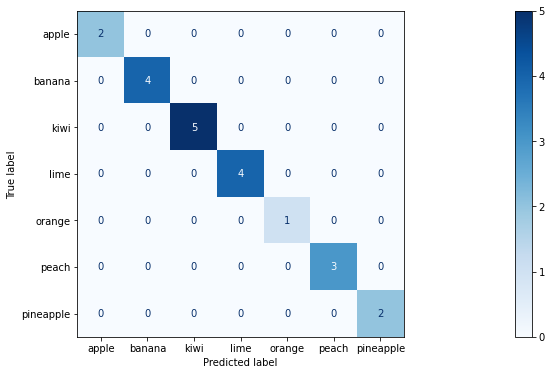

In [355]:
plt.rcParams["figure.figsize"] = (40,6)

cm = confusion_matrix(y_true, y_pred, labels = words)
disp = ConfusionMatrixDisplay(cm, display_labels = words)
disp = disp.plot(cmap=plt.cm.Blues)
plt.margins(0,0)
#plt.savefig('fruits_conf_mat.pdf', bbox_inches='tight')
plt.show()


# Compute Precision, Recall and F1 score indexes

In [251]:
precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, labels = words)
print('precision: ', precision)
print('recall: ', recall)
print('fscore: ', fscore)
print('support: ', support)

precision:  [1. 1. 1. 1. 1. 1. 1.]
recall:  [1. 1. 1. 1. 1. 1. 1.]
fscore:  [1. 1. 1. 1. 1. 1. 1.]
support:  [2 4 5 4 1 3 2]


In [356]:
total_samples = np.sum(support)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, \
                                                                             labels = words, average = 'macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred,\
                                                                             labels = words, average = 'weighted')

In [357]:
blank = [" ", " ", " ", " ", " "]
x = PrettyTable()
#x.set_style(PLAIN_COLUMNS)

column_names = ["\033[1mLabels", "Precision", "Recall", "Fscore", "Support\033[0m"]
#x.field_names = column_names
x.align["\033[1mLabels"] = "l"
x.add_column(column_names[0], words)
x.add_column(column_names[1],precision)
x.add_column(column_names[2],recall)
x.add_column(column_names[3],fscore)
x.add_column(column_names[4],support)
x.add_row(blank)
x.add_row(blank)

x.add_row(["\033[1m Avg \033[0m", precision_m, recall_m, fscore_m, total_samples])
x.add_row(["\033[1m Weighted Avg \033[0m", precision_w, recall_w, fscore_w, total_samples])
x.add_row(["\033[1m Accuracy \033[0m", "", "", accuracy, total_samples])





In [358]:
print(x)
with open('fruits_precision_recall_fscore_support.txt', 'w') as f:
    f.write(str(x))

+----------------+-----------+--------+--------+---------+
|     Labels     | Precision | Recall | Fscore | Support |
+----------------+-----------+--------+--------+---------+
|     apple      |    1.0    |  1.0   |  1.0   |    2    |
|     banana     |    1.0    |  1.0   |  1.0   |    4    |
|      kiwi      |    1.0    |  1.0   |  1.0   |    5    |
|      lime      |    1.0    |  1.0   |  1.0   |    4    |
|     orange     |    1.0    |  1.0   |  1.0   |    1    |
|     peach      |    1.0    |  1.0   |  1.0   |    3    |
|   pineapple    |    1.0    |  1.0   |  1.0   |    2    |
|                |           |        |        |         |
|                |           |        |        |         |
|      Avg       |    1.0    |  1.0   |  1.0   |    21   |
|  Weighted Avg  |    1.0    |  1.0   |  1.0   |    21   |
|    Accuracy    |           |        | 100.0  |    21   |
+----------------+-----------+--------+--------+---------+


# TEST ALL SPEECH SAMPLES FROM A SINGLE WORD

In [245]:
score_count = 0
words_number = 0
for word in test_dict_fruit.keys():
    test_samples = test_dict_fruit[word]
    test_samples = np.vstack(test_samples)

    

    #for speech_word in test_samples:
    words_number += 1
    score_models = {}
    for word_model in trained_model_fruit.keys():
        model = trained_model_fruit[word_model]
        score = model.score(test_samples)
        score_models[word_model] = score
    predict_word = max(score_models, key = score_models.get)
    print(word, ": ", predict_word)
    if predict_word == word:
        score_count += 1



print("Recognition rate %s" %(100 * score_count / words_number))
    
print("")

banana :  banana
lime :  lime
pineapple :  pineapple
kiwi :  kiwi
apple :  apple
peach :  peach
orange :  orange
Recognition rate 100.0

